In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

Fetch Stock Data from Yahoo Finance

In [3]:
def fetch_stock_data(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data[['Close']].values  # Using only the closing price

Preprocess for LSTM - Sequences of 60 days

In [4]:
def prepare_data(data, seq_length):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(seq_length, len(data_scaled)):
        X.append(data_scaled[i - seq_length:i, 0])
        y.append(data_scaled[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), scaler

Define the LSTM model

In [5]:
class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  #Take the last output for prediction
        return out

Train the LSTM Model

In [6]:
def train_model(model, train_loader, epochs=50, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

Predict and Plot Results

In [ ]:
def predict_and_plot(model, data, seq_length, scaler):
    model.eval()

    #Get last 'seq_length' days for prediction
    last_days = data[-seq_length:]
    last_days_scaled = scaler.transform(last_days)
    X_test = torch.tensor(last_days_scaled.reshape(1, seq_length, 1), dtype=torch.float32)

    predicted_price = model(X_test).detach().numpy()
    predicted_price = scaler.inverse_transform(predicted_price)  # Reverse scaling

    print(f"Predicted Next Day's Price: ${predicted_price[0][0]:.2f}")

    #Plot the actual vs predicted price
    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Actual Price', color='blue')
    plt.scatter(len(data), predicted_price, color='red', label='Predicted Price', marker='o', s=100)
    plt.title('Stock Price Prediction using PyTorch LSTM')
    plt.xlabel('Days')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    return predicted_price[0][0]

Main execution

In [8]:
stock_symbol = "AAPL"  #Can change to any stock symbol (e.g., TSLA, MSFT)
start_date = "2020-01-01"
end_date = "2024-03-01"
seq_length = 60  #Using last 60 days of data to predict next day

# Load and prepare data
data = fetch_stock_data(stock_symbol, start_date, end_date)
X, y, scaler = prepare_data(data, seq_length)

# Split into training and test sets
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Create DataLoader for training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize LSTM model
lstm_model = StockLSTM()
train_model(lstm_model, train_loader, epochs=50, lr=0.001)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Epoch 10/50, Loss: 0.001212
Epoch 20/50, Loss: 0.000676
Epoch 30/50, Loss: 0.000701
Epoch 40/50, Loss: 0.001067
Epoch 50/50, Loss: 0.000631


Predicted Next Day's Price: $179.78


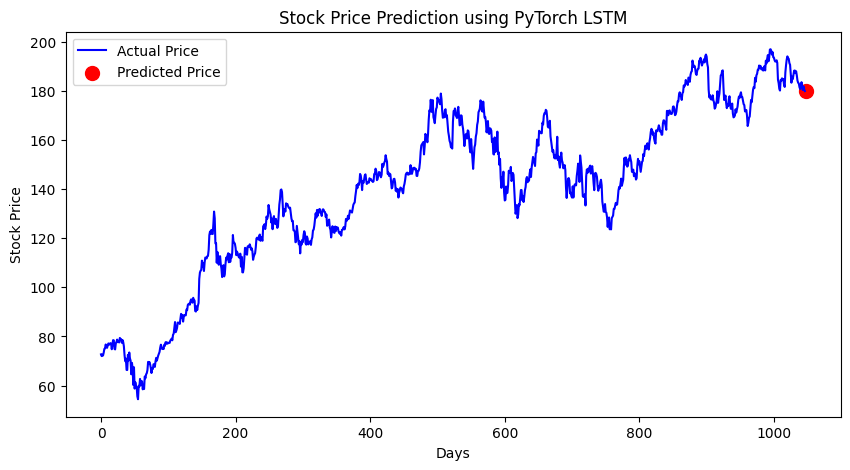

In [ ]:
# Predict Next Day's Stock Price
predicted_price= predict_and_plot(lstm_model, data, seq_length, scaler)

In [12]:
torch.save(lstm_model.state_dict(), "stock_lstm.pth")

Streamlit app

In [10]:
import streamlit as st

In [11]:
# Streamlit App UI
st.title("📈 Stock Price Prediction with LSTM")
stock_symbol = st.text_input("Enter Stock Symbol (e.g., AAPL, TSLA, MSFT):", "AAPL")
seq_length = st.slider("Select Sequence Length (Days):", 30, 100, 60)

if st.button("Predict"):
    with st.spinner("Fetching Data & Predicting..."):
        data = fetch_stock_data(stock_symbol, "2020-01-01", "2024-03-01")
        X, y, scaler = prepare_data(data, seq_length)

        # Load pre-trained LSTM model
        lstm_model.load_state_dict(torch.load("stock_lstm.pth"))  # Load trained model
        lstm_model.eval()

        predicted_price = predict_and_plot(lstm_model, data, seq_length, scaler)
        st.success(f"📌 Predicted Next Day's Price: **${predicted_price:.2f}**")

        # Plot data
        plt.figure(figsize=(10, 5))
        plt.plot(data, label="Actual Price", color="blue")
        plt.scatter(len(data), predicted_price, color="red", label="Predicted Price", marker="o", s=100)
        plt.title(f"{stock_symbol} Stock Price Prediction")
        plt.xlabel("Days")
        plt.ylabel("Stock Price")
        plt.legend()
        st.pyplot(plt)

2025-03-06 15:47:45.768 
  command:

    streamlit run C:\Users\Sanjana Rayarala\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py [ARGUMENTS]
